# Single person  lineage

In [1]:
import networkx as nx
import pandas as pd
import jdcal
from datetime import datetime
import networkx as nxxz
from jinja2 import Environment, FileSystemLoader
import networkx as nx
import jdcal



## Person of interest

In [2]:
# Define the birthday to explore
my_name = "Christian Dalager"
my_birthday = datetime(1973, 9, 20)
my_id = "christian_dalager"

skipImagePlot = True
forceImagePlotRegeneration = False

## Clean up data

In [3]:
df = pd.read_csv('born_and_died_cleaned.csv')

df = df.dropna(subset=['birthdate_jd', 'deathdate_jd'])
df['birthdate_jd'] = df['birthdate_jd'].astype(float)
df['deathdate_jd'] = df['deathdate_jd'].astype(float)

# remove all that are born on january 1st
# a lot of people with low precision birth and death dates are born on january 1st of a year or a century
# this could probably be filtered out earlier in the pipeline
def is_january_first(jd):
    _, month, day, _ = jdcal.jd2gcal(0, jd)
    return month == 1 and day == 1

# Remove all rows where birthdate_jd is January 1st
df = df[~df['birthdate_jd'].apply(is_january_first)]

# dataset size
print('size of dataset:', len(df))

# create a deathdate dict for fast lookups
deathdate_dict = df.groupby('deathdate_jd')['id'].apply(list).to_dict()


size of dataset: 1967690


## Add countries

There is a two small dataset with countries and historical countries, that we match up against the persons P27 value.

In [4]:
# get distinct df['P27] values
list = df['P27'].unique()
print('distinct P27 (country) values:', len(list))

# known countries
df_countries = pd.read_csv('countries.csv') 
df_countries['country'] = df_countries['country'].apply(lambda x: x.split('/')[-1])

df = df.merge(df_countries, left_on='P27', right_on='country', how='left')

# historical countries
df_countries = pd.read_csv('countries_historical.csv')
df_countries['country'] = df_countries['country'].apply(lambda x: x.split('/')[-1])

df = df.merge(df_countries, left_on='P27', right_on='country', how='left')
df['country'] = df['countryLabel_x'].combine_first(df['countryLabel_y'])

df = df.drop(columns=['country_x', 'country_y', 'countryLabel_x', 'countryLabel_y','P27'])

distinct P27 (country) values: 1337


## Add Person of interest to dataset

Putting the person of interest in the dataset

In [5]:

my_birthday_jd = sum(jdcal.gcal2jd(my_birthday.year,my_birthday.month,my_birthday.day))
my_age = datetime.now().year - my_birthday.year

new_row = {
    "id": my_id,
    "P569": my_birthday,
    "P570": None, # still alive and kicking
    "P27": None,
    "label": my_name,
    "sitelinks": None,
    "birthdate_jd": my_birthday_jd,
    "deathdate_jd": None,
    "age": my_age,
}
new_row_df = pd.DataFrame([new_row])
new_row_df = new_row_df.dropna(axis=1,how='all')
df = pd.concat([df, new_row_df], ignore_index=True)

# Build the graph

In [ ]:

# setting up some performance enhancing dictionaries
birthdate_dict = df.set_index('id')['birthdate_jd'].to_dict()
print('size of birthdate_dict:', len(birthdate_dict))

max_depth = 20
persons_to_explore = [my_id]

# Initialize the directed graph
G = nx.DiGraph()

# add the root node, the person we are exploring
G.add_node(my_id)

# Set to track processed persons
processed_persons = set()

# Function to process each person
def process_person(person_id):
    edges = []
    unprocessed_incarnations = []
    person_birthdate = birthdate_dict.get(person_id)
    # person has a birthdate and there are incarnation candidates in deathdate_dict
    if person_birthdate and person_birthdate in deathdate_dict:
        previous_incarnations = deathdate_dict[person_birthdate]
        for previous_self in previous_incarnations:
            if person_id != previous_self and previous_self not in processed_persons:
                # point from previous_self to person_id
                edges.append((previous_self,person_id))
                unprocessed_incarnations.append(previous_self)
    return edges, unprocessed_incarnations


# Iterate through each depth level
for depth in range(max_depth):
    if(len(persons_to_explore) == 0):
        print(f'No more persons to explore at depth {depth}')
        break
    print(f'Generation {depth}, looking at {len(persons_to_explore):,} persons')
    new_persons_to_explore = []

    # Process persons in the current depth level
    for person_id in persons_to_explore:
        if person_id not in processed_persons:
            edges, unprocessed_incarnations = process_person(person_id)
            G.add_edges_from(edges)
            new_persons_to_explore.extend(unprocessed_incarnations)
            processed_persons.add(person_id)

    # Update the list of persons to explore in the next depth level
    persons_to_explore = new_persons_to_explore

print(f'Number of persons / nodes: {G.number_of_nodes():,}')
print(f'Number of relations / edges: {G.number_of_edges():,}')

size of birthdate_dict: 1967691
Generation 0, looking at 1 persons
Generation 1, looking at 49 persons
Generation 2, looking at 761 persons
Generation 3, looking at 4,479 persons
Generation 4, looking at 12,933 persons
Generation 5, looking at 20,495 persons
Generation 6, looking at 15,829 persons
Generation 7, looking at 6,675 persons
Generation 8, looking at 1,802 persons
Generation 9, looking at 367 persons
Generation 10, looking at 58 persons
Generation 11, looking at 7 persons
Generation 12, looking at 2 persons
No more persons to explore at depth 13
Number of persons / nodes: 52,548
Number of relations / edges: 63,457


## Analyze graph

In [7]:
# graph size
import networkx

# most connected nodes
import operator

print('most connected nodes with edge count')
sorted_degree = sorted(G.degree, key=operator.itemgetter(1), reverse=True)
# name from df and degree
for node, degree in sorted_degree[:10]:
    person_id = df[df['id'] == node]
    name = person_id['label'].values[0]
    id = person_id['id'].values[0]    
    print(degree, id,name)


most connected nodes with edge count
110 Q464277 Jim Croce
66 Q107000074 Cosmus Blumer
49 christian_dalager Christian Dalager
38 Q105526918 Regina Kranzová
31 Q3852965 Maury Muehleisen
30 Q1783540 Eddie Murphy
29 Q18810723 Frederick McCalmont
28 Q5698620 Antonio Hernández Fajarnés
25 Q116865868 Tatsuji Motoi
24 Q4161346 Daniil Didenko


## Plot graph
Plotting the graph is the most compute intensive part of the notebook.

It may be skipped if you are not interested in the graph.


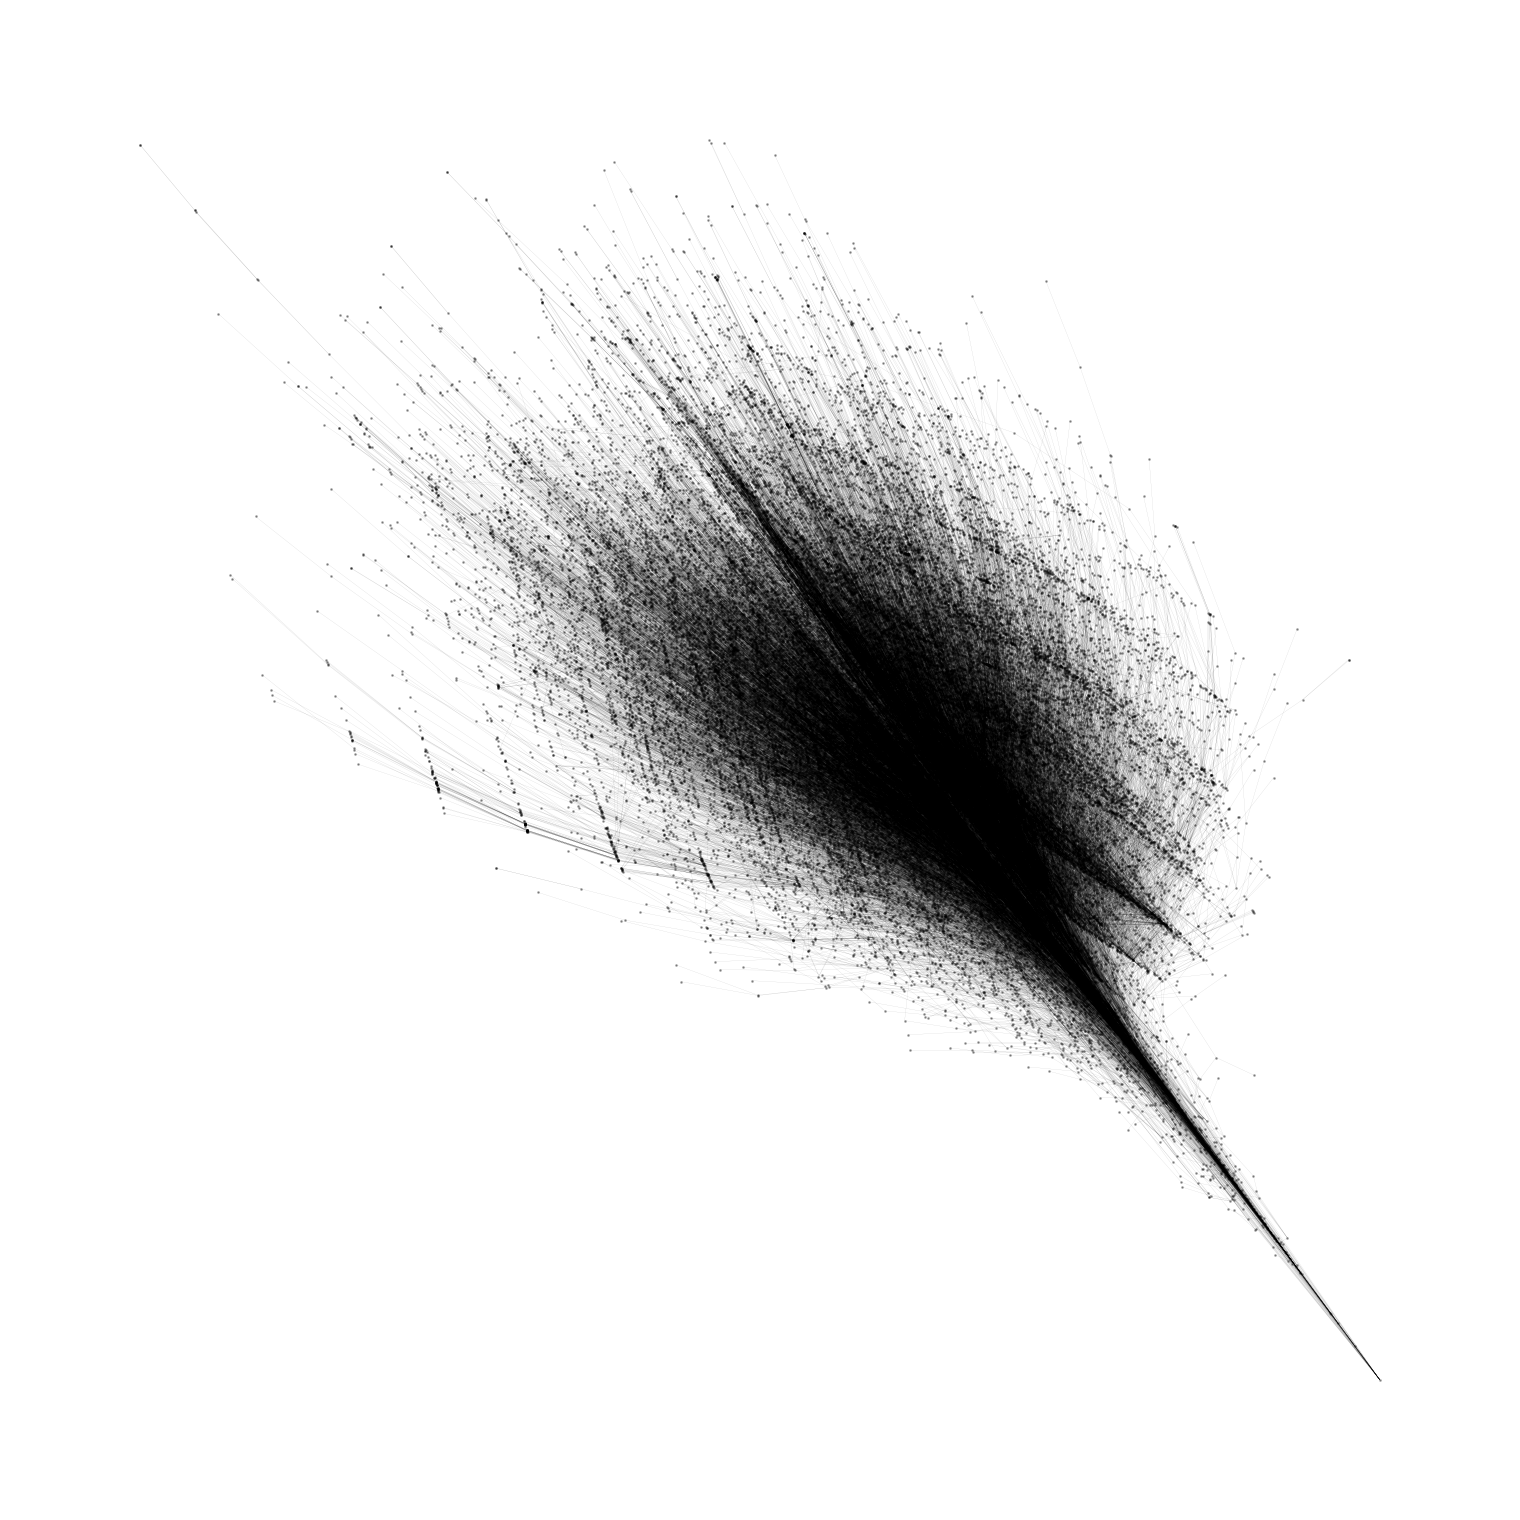

In [8]:
# 15 min for 21k nodes and 24 k edges in 20x20 inch plot 
import matplotlib.pyplot as plt

# check for file
import os
if os.path.exists(f"{my_id}.png"):
    skipImagePlot = True
    if forceImagePlotRegeneration:
        os.remove(f"{my_id}.png")
        skipImagePlot = False


if not skipImagePlot:
    # best for website    
    plt.figure(figsize=(15, 15))
    networkx.draw(
        G,
        with_labels=False,
        node_size=1,
        width=0.1,
        node_color="black",
        alpha=0.3,
        arrows=False,
        pos=networkx.spring_layout(G),
    )
    plt.axis("off")
    plt.savefig(f"{my_id}.png", dpi=300)


## Generate 10 longest lineage paths

In [9]:
import networkx as nx

all_pairs_lengths = dict(nx.all_pairs_dijkstra_path_length(G))

# Create a list of all paths with their lengths
all_paths = []
for source, target_lengths in all_pairs_lengths.items():
    for target, length in target_lengths.items():
        if source != target:
            path = nx.dijkstra_path(G, source, target)
            all_paths.append((length, path))

# Sort the paths by length in descending order
all_paths.sort(key=lambda x: x[0], reverse=True)

# Get the top 10 longest paths
top_10_longest_paths = all_paths[:10]


## Create html file

In [10]:
# setup the template viewmodel
import json

reincarnation_paths = []

for length, path in top_10_longest_paths:
    path_nodes = []
    df_subset = df[df["id"].isin(path)]
    df_subset = df_subset.sort_values("birthdate_jd")
    for i, row in df_subset.iterrows():
        rowdict = row.to_dict()
        name = rowdict["label"]
        id = rowdict["id"]
        if not pd.isna(rowdict["birthdate_jd"]):
            birthdate = jdcal.jd2gcal(0, rowdict["birthdate_jd"])
            birthdate = datetime(birthdate[0], birthdate[1], birthdate[2])
            birthdate = birthdate.strftime("%Y-%m-%d")
        if not pd.isna(rowdict["deathdate_jd"]):
            deathdate = jdcal.jd2gcal(0, rowdict["deathdate_jd"])
            deathdate = datetime(deathdate[0], deathdate[1], deathdate[2])
            deathdate = deathdate.strftime("%Y-%m-%d")
        if(id==my_id):
            deathdate=""
        country = rowdict["country"] if not pd.isna(rowdict["country"]) else ""
        age = round(rowdict["age"])
        
        wikidata = f"https://www.wikidata.org/wiki/{id}"

        if not pd.isna(rowdict["sitelinks"]):
            sl = rowdict["sitelinks"]
            sl = sl.replace("'", '"')
            try:
                j = json.loads(sl)
                if(j != None and j.keys() != None and len(j.keys()) > 0):
                    jkeys = j.keys()
                    prefixes = [key[:-4] for key in jkeys]
                    langkey = None
                    if("en" in prefixes):
                        langkey="en"
                    else:
                        # take first
                        langkey = prefixes[0]
                    wikilink = f"https://www.wikidata.org/wiki/Special:GoToLinkedPage/{langkey}/{id}"
                else:
                    wikilink=None
                
            except Exception as e:
                wikilink=None

        path_nodes.append(
            {
                "id": id,
                "name": name,
                "birthdate": birthdate,
                "deathdate": deathdate,
                "country": country,
                "age": age,
                "wikilink": wikilink,
                "wikidata": wikidata,
            }
        )
    reincarnation_paths.append({"length": length, "path": path_nodes})

has_plot = os.path.exists(f"{my_id}.png")

person = {"name": my_name, "birthday": my_birthday,"id": my_id, "incarnationcount": G.number_of_nodes()}
model = {"hasPlot":has_plot,"person": person, "reincarnation_paths": reincarnation_paths, "generated": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

In [ ]:

# setup the template
file_loader = FileSystemLoader(".")
env = Environment(loader=file_loader)
template = env.get_template("htmltemplate.jinja")
output = template.render(model)
with open(f'{my_id}.html', 'w',encoding="utf8") as f:
    f.write(output)
